In [1]:
%matplotlib notebook

import os
from os.path import isfile, join
import numpy as np
from PIL import Image, ImageOps
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy.geometry import Point, Circle
import imageio

In [79]:
#!/usr/bin/env python3.6
# -*- Coding: UTF-8 -*-
"""
Defisheye algorithm.
Developed by: E. S. Pereira.
e-mail: pereira.somoza@gmail.com
Based in the work of F. Weinhaus.
http://www.fmwconcepts.com/imagemagick/defisheye/index.php
Copyright [2019] [E. S. Pereira]
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
"""
import cv2
from numpy import arange, sqrt, arctan, sin, tan, zeros, array, meshgrid, pi, ndarray
from numpy import argwhere, hypot


class Defisheye:
    """
    Defisheye
    fov: fisheye field of view (aperture) in degrees
    pfov: perspective field of view (aperture) in degrees
    xcenter: x center of fisheye area
    ycenter: y center of fisheye area
    radius: radius of fisheye area
    angle: image rotation in degrees clockwise
    dtype: linear, equalarea, orthographic, stereographic
    format: circular, fullframe
    """

    def __init__(self, infile, **kwargs):
        vkwargs = {"fov": 180,
                   "pfov": 120,
                   "xcenter": None,
                   "ycenter": None,
                   "radius": None,
                   "angle": 0,
                   "dtype": "equalarea",
                   "format": "fullframe"
                   }
        self._start_att(vkwargs, kwargs)

        if type(infile) == str:
            _image = cv2.imread(infile)
        elif type(infile) == ndarray:
            _image = infile
        else:
            raise ImageError("Image format not recognized")


        width = _image.shape[1]
        height = _image.shape[0]
        xcenter = width // 2
        ycenter = height  // 2

        dim = min(width, height)
        x0 = xcenter - dim // 2
        xf = xcenter + dim // 2
        y0 = ycenter - dim // 2
        yf = ycenter + dim // 2

        self._image = _image[y0:yf, x0:xf, :]

        self._width = self._image.shape[1]
        self._height = self._image.shape[0]

        if self._xcenter is None:
            self._xcenter = (self._width - 1) // 2

        if self._ycenter is None:
            self._ycenter = (self._height - 1) // 2

    def _map(self, i, j, ofocinv, dim):

        xd = i - self._xcenter
        yd = j - self._ycenter

        rd = hypot(xd, yd)
        phiang = arctan(ofocinv * rd)

        if self._dtype == "linear":
            ifoc = dim * 180 / (self._fov * pi)
            rr = ifoc * phiang
            # rr = "rr={}*phiang;".format(ifoc)

        elif self._dtype == "equalarea":
            ifoc = dim / (2.0 * sin(self._fov * pi / 720))
            rr = ifoc * sin(phiang / 2)
            # rr = "rr={}*sin(phiang/2);".format(ifoc)

        elif self._dtype == "orthographic":
            ifoc = dim / (2.0 * sin(self._fov * pi / 360))
            rr = ifoc * sin(phiang)
            # rr="rr={}*sin(phiang);".format(ifoc)

        elif self._dtype == "stereographic":
            ifoc = dim / (2.0 * tan(self._fov * pi / 720))
            rr = ifoc * tan(phiang / 2)

        rdmask = rd != 0
        xs = xd.copy()
        ys = yd.copy()

        xs[rdmask] = (rr[rdmask] / rd[rdmask]) * xd[rdmask] + self._xcenter
        ys[rdmask] = (rr[rdmask] / rd[rdmask]) * yd[rdmask] + self._ycenter

        xs[~rdmask] = 0
        ys[~rdmask] = 0

        xs = xs.astype(int)
        ys = ys.astype(int)
        return xs, ys

    def convert(self, outfile):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius

        # compute output (perspective) focal length and its inverse from ofov
        # phi=fov/2; r=N/2
        # r/f=tan(phi);
        # f=r/tan(phi);
        # f= (N/2)/tan((fov/2)*(pi/180)) = N/(2*tan(fov*pi/360))

        ofoc = dim / (2 * tan(self._pfov * pi / 360))
        ofocinv = 1.0 / ofoc

        i = arange(self._width)
        j = arange(self._height)
        i, j = meshgrid(i, j)

        xs, ys, = self._map(i, j, ofocinv, dim)
        img = self._image.copy()

        img[i, j, :] = self._image[xs, ys, :]
        return img

    def _start_att(self, vkwargs, kwargs):
        """
        Starting atributes
        """
        pin = []

        for key, value in kwargs.items():
            if key not in vkwargs:
                raise NameError("Invalid key {}".format(key))
            else:
                pin.append(key)
                setattr(self, "_{}".format(key), value)

        pin = set(pin)
        rkeys = set(vkwargs.keys()) - pin
        for key in rkeys:
            setattr(self, "_{}".format(key), vkwargs[key])

In [106]:
def defish(n):
    elem = video_list[n]
    video_path= PATH + elem
    name = elem[0:-4]
    video_output_path = OUT_PATH + name + "_defisheyed.mp4"
    img_out = ""

    xcenter = int(defish_settings[elem][1])+1 #round up
    ycenter = int(defish_settings[elem][2])+1
    radius = int(defish_settings[elem][0])+1
    space = 300
    frame_y_start = ycenter+space-radius
    frame_y_end = ycenter+space+radius
    frame_x_start = xcenter+space-radius
    frame_x_end = xcenter+space+radius
    
    video = imageio.get_reader(video_path,  'ffmpeg')
    frame_number = video.count_frames()
    defished_movie = None

    for frame_index in range(frame_number):
        frame = vid.get_data(frame_index)
        padded_single_color_frames = []
        for rgb_index in range(3):
            frame_single_color_channel = frame[..., rgb_index].copy()
            frame_single_color_channel = np.pad(frame_single_color_channel, space, constant_values = 255)
            padded_single_color_frames.append(frame_single_color_channel)
        
        padded_frame = np.asarray(padded_single_color_frames)
        padded_frame = np.moveaxis(padded_frame, 0, -1)
        padded_frame = padded_frame[frame_y_start:frame_y_end, frame_x_start:frame_x_end] #crop the image
        obj = Defisheye(padded_frame, dtype=defish_dtype, format=defish_format, fov=defish_fov, pfov=defish_pfov, radius=radius, xcenter=radius, ycenter=radius)
        defish_frame = obj.convert(img_out)        
        
        if type(defished_movie) == type(None):
            defished_movie = np.expand_dims(defish_frame, 0)
        else:
            defish_frame_in_4d = np.expand_dims(defish_frame, 0)
            defished_movie = np.append(defished_movie, defish_frame_in_4d, axis=0)
            
        if frame_index%10 == 0:
            print(frame_index)
            
        
    writer = imageio.get_writer(video_output_path, fps=fps)

    for frame_index in range(defished_movie.shape[0]):
        writer.append_data(defished_movie[frame_index])
    writer.close()


def onclick(event):
    x = event.xdata
    y = event.ydata
    three_points.append([x, y])
    
def update_defish_settings(n, three_points):
        c2 = Circle(Point(three_points[0]), Point(three_points[1]), Point(three_points[2]))
      
        radius = float(c2.radius)
        xcenter = float(c2.center.x)
        ycenter = float(c2.center.y)
        
        defish_settings[video_list[n]] = [radius, xcenter, ycenter]
        
        three_points=[]
        
def show_circle(n):
    video_path = PATH + video_list[n]
    video = cv2.VideoCapture(video_path)

    ret, frame = video.read()
    if ret:
        height, width, layers = frame.shape
        fig, ax = plt.subplots()
        im_extent = 0, width, 0, height
        ax.imshow(frame, extent = im_extent)
        c = patches.Circle((defish_settings[video_list[n]][1], defish_settings[video_list[n]][2]), radius=defish_settings[video_list[n]][0], fill =False, color="green", linewidth=2)
        ax.add_artist(c)
        plt.scatter(defish_settings[video_list[n]][1], defish_settings[video_list[n]][2])
        plt.show()
        
def get_points_for_circle(n):
    video_path = PATH + video_list[n]
    video = cv2.VideoCapture(video_path)

    three_points.clear()
    ret, frame = video.read()
    if ret:
        height, width, layers = frame.shape
        fig, ax = plt.subplots()
        im_extent = 0, width, 0, height
        ax.imshow(frame, extent = im_extent)
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        
        plt.show
        
def initialize_variables():
    global defish_dtype, defish_format, defish_fov, defish_pfov, video_list, three_points, defish_settings
    
    defish_dtype = 'linear'
    defish_format = 'fullframe'
    defish_fov = 180
    defish_pfov = 120
    
    video_list = [files for files in os.listdir(PATH) if files.endswith(".mp4")]
    three_points=[]
    defish_settings = {}

    print(video_list)

Define input variables

In [88]:
PATH = "C:\\Users\\kobel\\Documents\\Medizin\\Doktorarbeit\\Data\\Crop_Videos\\"
fps = 40
OUT_PATH = "C:\\Users\\kobel\\Documents\\Medizin\\Doktorarbeit\\Data\\Defish_Videos\\"

initialize_variables()

['210_F1-66_220331_OTT_Trim.mp4', '210_F1-66_220331_OTT_Trim2.mp4', '210_F1-66_220331_OTT_Trim3.mp4', '210_F1-66_220403_OTE_Trim.mp4', '210_F1-66_220403_OTE_Trim2.mp4', '210_F1-71_220331_OTR_Trim.mp4', '210_F1-71_220331_OTR_Trim2.mp4', '210_F1-71_220331_OTR_Trim3.mp4', '210_F1-71_220403_OTT_Trim.mp4', '210_F1-71_220403_OTT_Trim2.mp4', '210_F1-71_220403_OTT_Trim3.mp4', '210_F1-71_220403_OTT_Trim4.mp4', '211_F1-3_220323_OTR_Trim.mp4', '211_F1-3_220323_OTR_Trim2.mp4', '211_F1-3_220323_OTR_Trim3.mp4', '211_F1-3_220323_OTR_Trim4.mp4', '211_F1-3_220323_OTR_Trim5.mp4', '211_F1-3_220323_OTR_Trim6.mp4', '211_F1-3_220326_OTT_Trim.mp4', '211_F1-3_220326_OTT_Trim2.mp4', '211_F1-3_220326_OTT_Trim3.mp4', '211_F1-3_220326_OTT_Trim4.mp4', '211_F1-3_220326_OTT_Trim5.mp4', '211_F1-3_220328_OTT_Trim.mp4', '211_F1-3_220331_OTE_Trim.mp4', '211_F1-3_220331_OTE_Trim2.mp4', '211_F1-3_220331_OTE_Trim3.mp4', '211_F1-3_220403_OTR_Trim.mp4', '211_F1-3_220403_OTR_Trim2.mp4', '211_F1-3_220403_OTR_Trim3.mp4']


Run the following Code for each element in video_list individually.

<IPython.core.display.Javascript object>


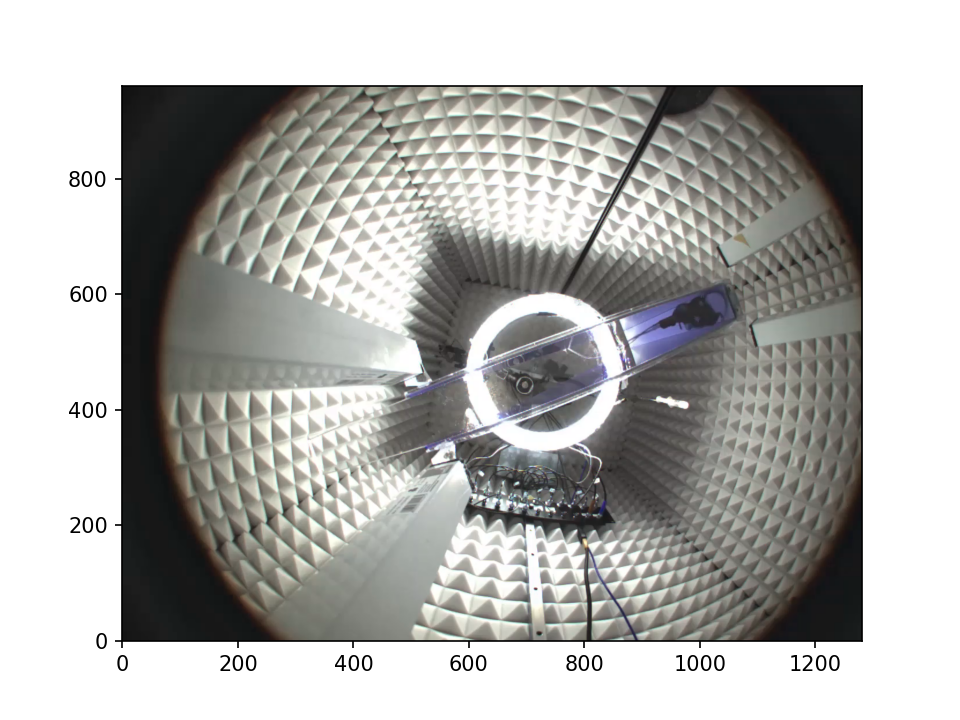

In [89]:
n = 0 # = indexing elements in video_list
get_points_for_circle(n)

<IPython.core.display.Javascript object>


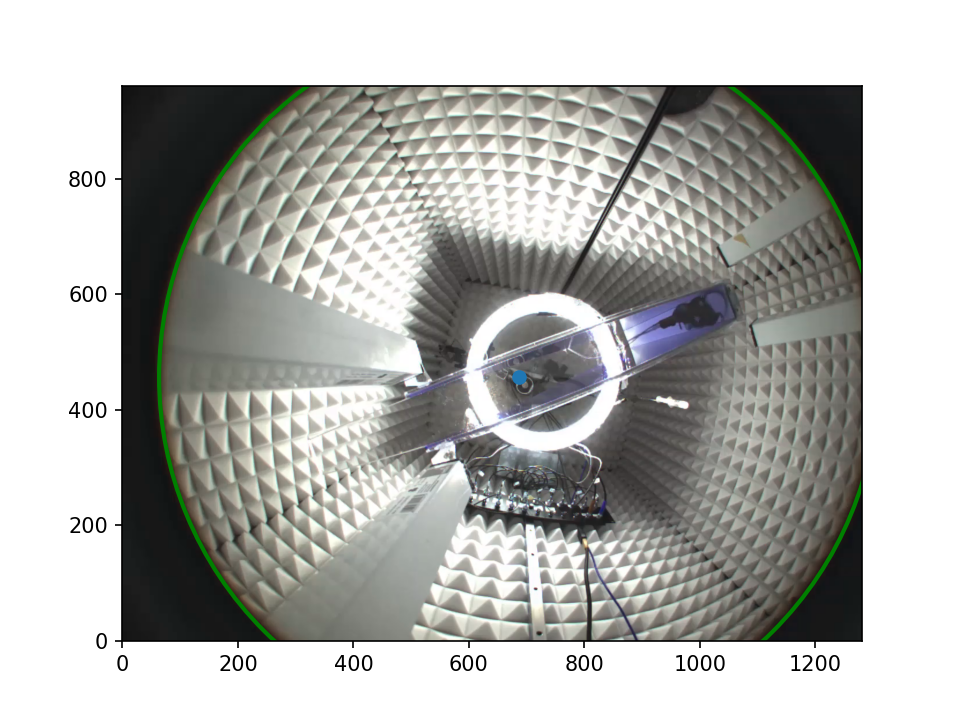

In [91]:
update_defish_settings(n, three_points)
show_circle(n) #not necessary, just to confirm, that the points are drawn correctly

In [107]:
for n in range(len(video_list)):
    defish(n)

0
10
20
30
40


KeyboardInterrupt: 